#Week 5: HCP Interpretability

Tutorial by Cher Bass


Here, we demonstrate implementation of feature attribution for medical imaging analysis making use of the [Captum visualisation library](https://captum.ai/)

Let's start by importing the modules and Data that we need for the notebook. The data is available from [here](https://drive.google.com/drive/folders/1nKemkHflB3L1eMQu3Z0kbatlBEYwWoQP?usp=sharing)

To use data from the shared drive:

- log into google drive and accept the invitation to share the folder/file. You should see the folder 'coursework1-data' under "shared with me" on the left side.
- Click on the folder / file so that they turn blue and are highlighted (do not enter the folder)
- Click on the three vertical dots and click "Add to My Drive".
- make sure the path below matches the path relative to your drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# change current directory to appropriate folder
#%cd '/content/drive/My Drive/Colab Notebooks/Colab_Data/hcp_tutorial/'
%cd '/content/drive/My Drive/Colab Notebooks/hcp_tutorial/'

import torch
import torch.nn as nn
import torch.nn.functional as F #contains some useful functions like activation functions & convolution operations you can use
import os
import torchvision
import numpy as np
from torchvision import datasets, models, transforms
from HCP_Dataset import *
from skimage.transform import resize
from torch.utils.data.sampler import SubsetRandomSampler
import time
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from PIL import Image

__location__ = os.path.realpath(
    os.path.join(os.getcwd(), os.path.dirname('__file__')))

# create a results folder for saving experiments
print(__location__)
results_path = os.path.join(__location__,'results')
if not os.path.exists(results_path):
    os.makedirs(results_path)

# ----------------------------------- Data Loading ----------------------------
# This is used to resize the images 
transforms = []
transforms.append(ResizeImage(image_size=(128, 160)))
transforms = torchvision.transforms.Compose(transforms)

hcp_train = HCP_2d_dataset(image_path=__location__ + '/hcp_data', blob_labels=__location__ + '/hcp_blob_labels', 
                                mask_path=__location__ + '/hcp_blob_masks', brain_regions=(), transform=transforms)

# for lesion dataset can choose which brain regions to add lesions to (1 to 8 areas)
hcp_lesions_train = HCP_2d_dataset(image_path=__location__ + '/hcp_data', blob_labels=__location__ + '/hcp_blob_labels', 
                                mask_path=__location__ + '/hcp_blob_masks', brain_regions=(1,2,3,4,5,6,7,8), transform=transforms)

# Get indices for train and validation datasets, and split the data
indices = list(range(len(hcp_train))) 
split = int(len(indices)*0.2) 
validation_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(validation_idx))
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

# Train and val dataloader for baseline data
train_hcp_loader = torch.utils.data.DataLoader(hcp_train, batch_size = 2,
                                           sampler=train_sampler) 
val_hcp_loader = torch.utils.data.DataLoader(hcp_train, batch_size = 2,
                                        sampler=validation_sampler)

# Train and val dataloader for lesions data
train_hcp_lesions_loader = torch.utils.data.DataLoader(hcp_lesions_train, batch_size = 2,
                                           sampler=train_sampler) 
val_hcp_lesions_loader = torch.utils.data.DataLoader(hcp_lesions_train, batch_size = 2,
                                        sampler=validation_sampler) 
# ----------------------------------------------------------------------------


Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/hcp_tutorial
/content/drive/My Drive/Colab Notebooks/hcp_tutorial


Check your device to cuda (if you have access to a GPU) or cpu otherwise 


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Human Connectome Project Dataset

Here, we use the HCP dataset, with T2 MRI data, for simulating lesions in MRI brain slices. We use the original data as class 0 (no lesions), and then create cortical 'lesions' which appear in the 'disease' class 1, with different frequencies (see image below). During training, we take 2D axial slices from the centre of the brain, to reduce computational contrainsts. 

Our task will be classification of 2D MRI slice data with and without lesions from this dataset.


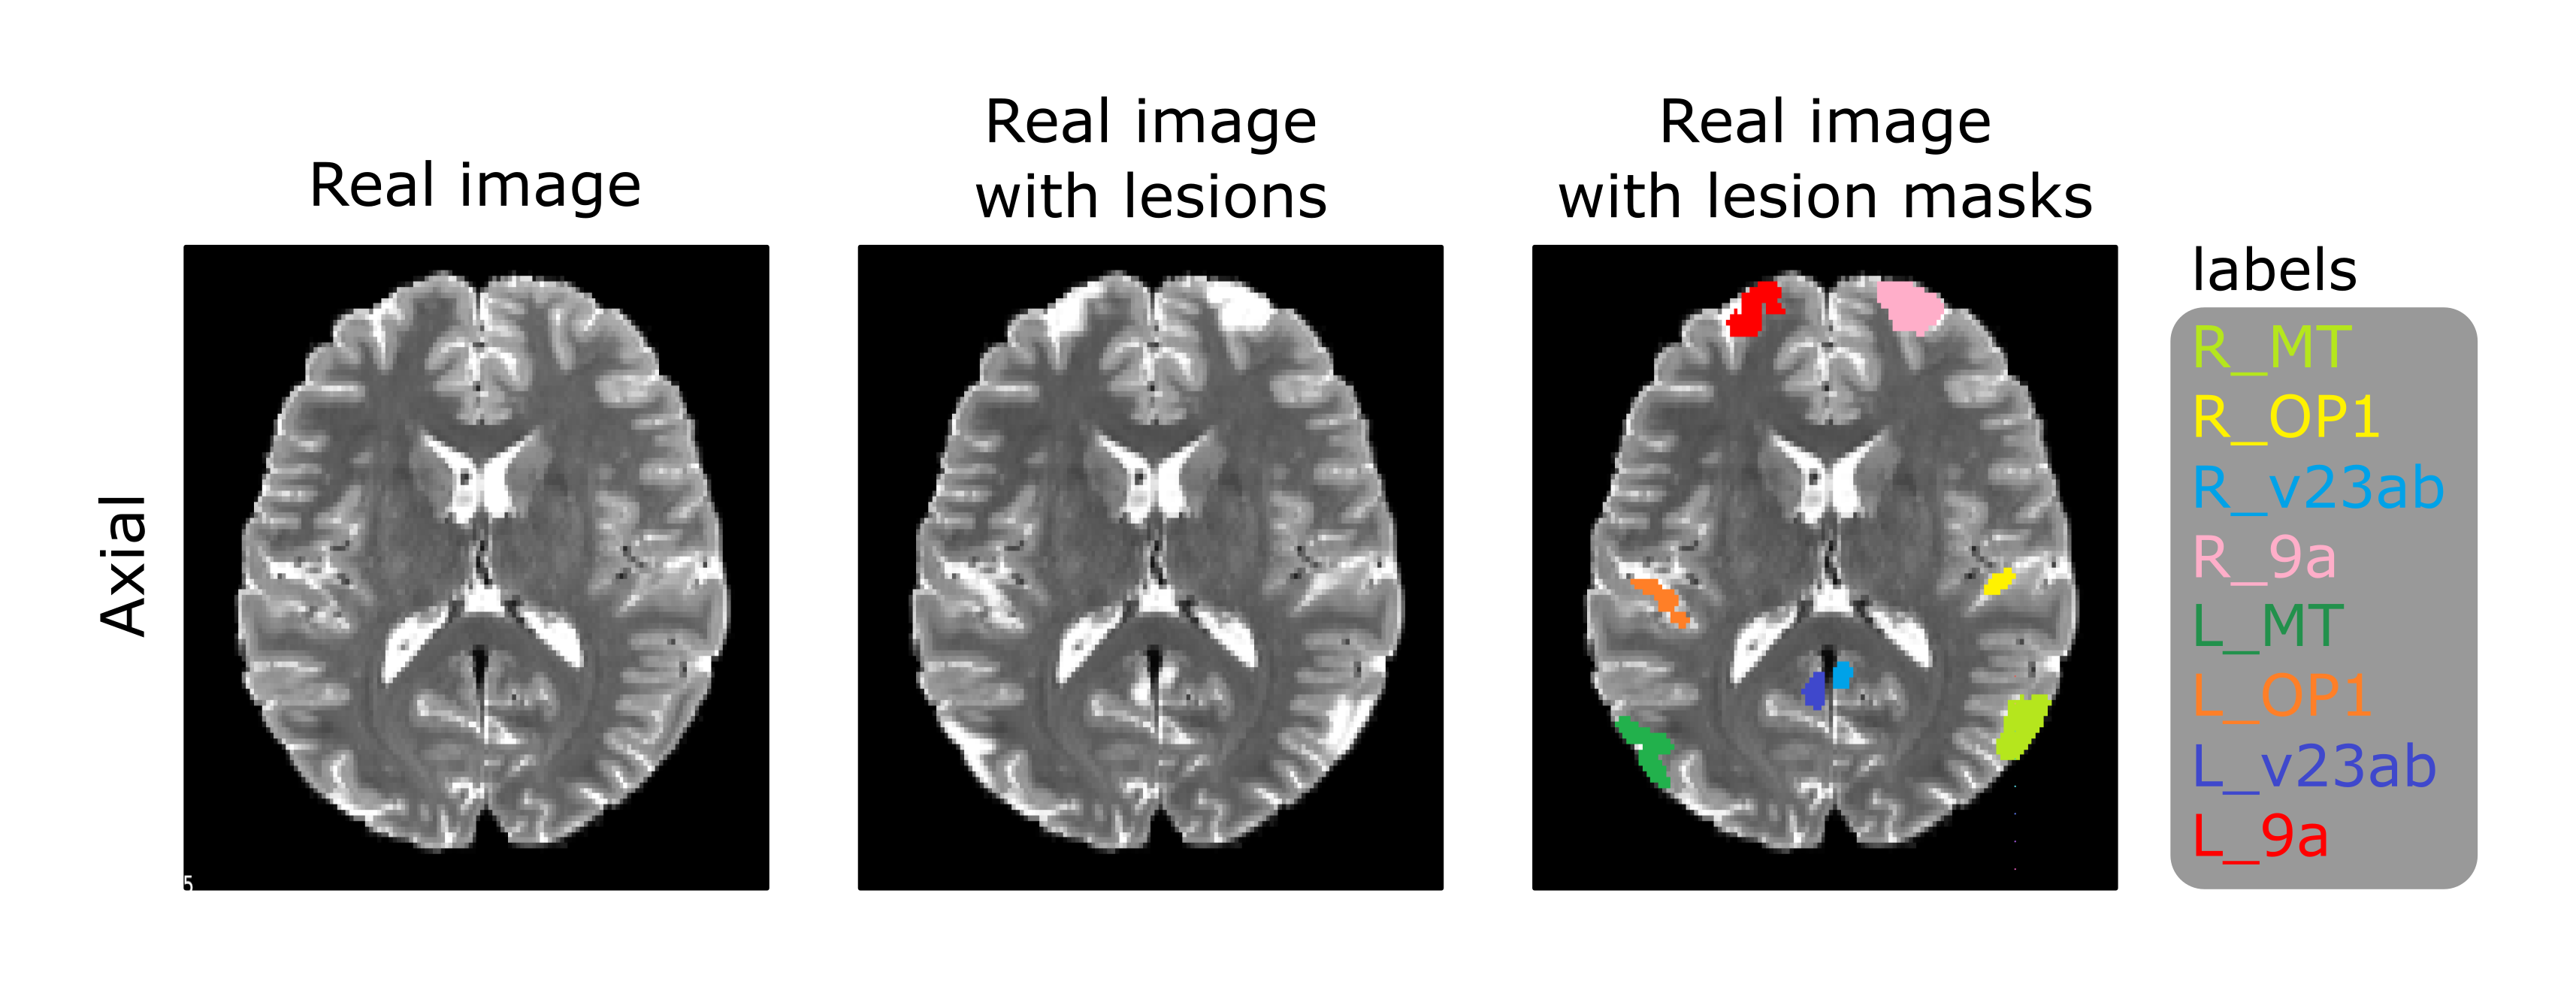



Bass C, Silva MD, Sudre CH, Tudosiu PD, Smith SM, Robinson EC. ICAM: Interpretable Classification via Disentangled Representations and Feature Attribution Mapping. NeurIPS 2020.

## Build a Res-net for classification 

We next build our resnet network.


In [4]:
class ResidualBlock(nn.Module):

    def __init__(self, channels1,channels2,res_stride=1):
        super(ResidualBlock, self).__init__()
        self.inplanes=channels1
        self.conv1 = nn.Conv2d(channels1, channels2, kernel_size=3, stride=res_stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels2)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(channels2, channels2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels2)

        if res_stride != 1 or channels2 != channels1:
            self.shortcut=nn.Sequential(
                nn.Conv2d(channels1, channels2, kernel_size=1, stride=res_stride, bias=False),
                nn.BatchNorm2d(channels2))
        else:
            self.shortcut=nn.Sequential()
            

    def forward(self, x):
        
        out=self.conv1(x)
        out=self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_strides, num_features, in_channels, FC_channels,num_classes=1):
        '''
        Constructor input:
            block: instance of residual block class
            num_blocks: how many layers per block (used in _make_layer)
            num_strides: list with number of strides for each layer (see Lecture 3)
            num_features: list with number of features for each layer
            FC_Channels: number of inputs expected for the fully connected layer (must
                        equal the total number of activations returned from preceding layer)
            num_classes: (number of outputs of final layer)
        '''
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(in_channels, num_features[0], kernel_size=7, stride=num_strides[0], padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.layer1 = self._make_layer(block, num_features[1], num_blocks, stride=num_strides[1])
        self.layer2 = self._make_layer(block, num_features[2], num_blocks, stride=num_strides[2])
        self.layer3 = self._make_layer(block, num_features[3], num_blocks, stride=num_strides[3])
        self.linear1 = nn.Linear(FC_channels, 1024)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(1024, num_classes)
        self.softmax = nn.Softmax(dim=1)


    def _make_layer(self, block, planes, num_blocks, stride):
        '''
        This creates each residual layer by stacking residual blocks
        '''
        layers = []
        
        for i in np.arange(num_blocks -1):
            layers.append(block(self.in_planes, planes))
            self.in_planes = planes 
        
        layers.append(block(planes, planes, stride))
        
        return nn.Sequential(*layers)

    def forward(self, x):

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.linear2(out)
        return out

def my_ResNet(in_channels=1):
  return ResNet(ResidualBlock,2, [2,2,2,2], [16,32,64,96], in_channels=1, FC_channels = 7680, num_classes = 2)

resnet = (my_ResNet(in_channels=1)).to(device)


In [5]:
#define your optimiser and losses
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)


## Training and evaluating our classification network
We next train and evaluate our network 

note that the results are saved to a folder \results - so please check that

In [6]:
epochs = 10
e = np.arange(epochs)
val_accuracy = np.zeros(epochs)
val_loss = np.zeros(epochs)

for epoch in range(epochs):
    it = 0
    healthy_data_iter = iter(train_hcp_loader)
    anomaly_data_iter = iter(train_hcp_lesions_loader)

    while it < len(train_hcp_loader) and it < len(train_hcp_lesions_loader):

        healthy_images, _, _ = healthy_data_iter.next()
        anomaly_images, _, _ = anomaly_data_iter.next()
        healthy_c_org = torch.zeros((healthy_images.size(0))).to(device)
        anomaly_c_org = torch.ones((anomaly_images.size(0))).to(device)
        data = torch.cat((healthy_images, anomaly_images), dim=0).type(torch.FloatTensor)
        labels = torch.cat((healthy_c_org, anomaly_c_org), dim=0).type(torch.LongTensor)

        resnet.train()
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = resnet(data)        
        loss = loss_fun(outputs, labels)
        loss.backward()
        optimizer.step()
        
        ce_loss = loss.item()
        if it % 10 == 0:
            print('[%d, %5d] loss: %.6f' %
                 (epoch + 1, it + 1, ce_loss))
        it = it+1

    l_pred = np.zeros(0)
    l_true = np.zeros(0)
    l_loss = np.zeros(0)

    it = 1
    healthy_val_data_iter = iter(val_hcp_loader)
    anomaly_val_data_iter = iter(val_hcp_lesions_loader)

    while it < len(val_hcp_lesions_loader) and it < len(val_hcp_loader):
        healthy_images, _, _ = healthy_val_data_iter.next()
        anomaly_images, _, _ = anomaly_val_data_iter.next()

        healthy_c_org = torch.zeros((healthy_images.size(0))).to(device)
        anomaly_c_org = torch.ones((anomaly_images.size(0))).to(device)
        data = torch.cat((healthy_images, anomaly_images), dim=0).type(torch.FloatTensor)
        labels = torch.cat((healthy_c_org, anomaly_c_org), dim=0).type(torch.LongTensor)

        data = data.to(device)
        labels = labels.to(device)
        resnet.eval()
        outputs = resnet(data)

        loss = loss_fun(outputs, labels)
        loss = np.array([loss.item()])
        y_score = F.softmax(outputs, dim=0)
        _, y_pred = torch.max(y_score, 1)

        l_loss = np.append(l_loss, loss, axis=0)
        l_pred = np.append(l_pred, y_pred.data.cpu().numpy(), axis=0)
        l_true = np.append(l_true, labels.data.cpu().numpy(), axis=0)
        it = it+1

    accuracy = accuracy_score(l_true, l_pred)
    val_accuracy[epoch] = accuracy
    val_loss[epoch] = np.mean(l_loss)
    state = resnet.state_dict()
    torch.save(state, results_path+'/model.pth')

    print(['Val Accuracy:', val_accuracy[epoch]])
    print(['Val Loss:', val_loss[epoch]])

    np.save(results_path+'/val_accuracy.npy', val_accuracy)
    np.save(results_path+'/val_loss.npy', val_loss)

    if (val_accuracy[epoch] >= np.max(val_accuracy)):
        torch.save(state, results_path+'/best_val_model.pth')

    plt.figure()
    plt.plot(e[:epoch + 1], val_accuracy[:epoch + 1], label='val_accuracy score')
    plt.xlabel('val save iterations')
    plt.legend()
    plt.title('val_accuracy score')
    plt.savefig(results_path + '/val_accuracy.png')
    plt.close()

    plt.figure()
    plt.plot(e[:epoch + 1], val_loss[:epoch + 1], label='val_loss')
    plt.xlabel('val save iterations')
    plt.legend()
    plt.title('val_loss')
    plt.savefig(results_path + '/val_loss.png')
    plt.close()


[1,     1] loss: 0.725244
[1,    11] loss: 0.726311
[1,    21] loss: 0.607208
[1,    31] loss: 0.582569
[1,    41] loss: 0.377678
[1,    51] loss: 0.051936
[1,    61] loss: 0.006769
[1,    71] loss: 0.104021
[1,    81] loss: 0.017783
[1,    91] loss: 0.349098
[1,   101] loss: 0.177678
[1,   111] loss: 0.113827
[1,   121] loss: 0.018565
[1,   131] loss: 0.004821
[1,   141] loss: 0.036019
[1,   151] loss: 0.015116
[1,   161] loss: 0.002451
[1,   171] loss: 0.000303
['Val Accuracy:', 0.9651162790697675]
['Val Loss:', 0.10440681383777194]
[2,     1] loss: 0.001058
[2,    11] loss: 0.060358
[2,    21] loss: 0.000063
[2,    31] loss: 0.000038
[2,    41] loss: 0.008537
[2,    51] loss: 0.001520
[2,    61] loss: 0.001046
[2,    71] loss: 0.000221
[2,    81] loss: 0.000158
[2,    91] loss: 0.001705
[2,   101] loss: 0.057588
[2,   111] loss: 0.000077
[2,   121] loss: 0.401213
[2,   131] loss: 0.814345
[2,   141] loss: 0.000718
[2,   151] loss: 0.010659
[2,   161] loss: 0.008476
[2,   171] loss: 

## Interpretability methods - Integrated Gradients and Guided backprop

Here we will use the Captum libarary to apply integrated gradients and guided backprop to the model trained on the HCP lesion data. 

We first need to install the library.

In [7]:
!pip install captum
from captum.attr import IntegratedGradients
from captum.attr import GuidedBackprop
from captum.attr import Occlusion
from captum.attr import visualization as viz


     |████████████████████████████████| 4.4MB 16.0MB/s 


We apply Integrated Gradients, and Guided Backprop. 
See the following links for further information of how to use these methods:
https://captum.ai/docs/extension/integrated_gradients

https://captum.ai/api/guided_backprop.html

We apply these methods to single images, but get an average by applying the methods to the entire test dataset, and then taking the mean or max across the subejcts. We find that taking the average works better, as applying to single images gives very low activations.


In [8]:
#running visualisation methods on test data
healthy_val_data_iter = iter(val_hcp_loader)
anomaly_val_data_iter = iter(val_hcp_lesions_loader)

ig_images= torch.zeros((len(val_hcp_lesions_loader), 1, 128, 160))
gc_images= torch.zeros((len(val_hcp_lesions_loader), 1, 128, 160))
images= torch.zeros((len(val_hcp_lesions_loader), 1, 128, 160))
masks = torch.zeros((len(val_hcp_lesions_loader), 1, 128, 160))

for i, (image, _, mask) in enumerate(val_hcp_lesions_loader,0):
    print(i)
    label = torch.ones(1).long()
    image = image.to(device)
    image = image[0].unsqueeze(dim=0)
    output = resnet(image)

    ig = IntegratedGradients(resnet)
    ig_images[i], delta = ig.attribute(image.detach(), baselines= 0, target=0, return_convergence_delta=True)

    gc = GuidedBackprop(resnet)
    gc_images[i] = gc.attribute(image,target=label)

    images[i] = image
    masks[i] = mask[0].unsqueeze(dim=0)

    if i == 0:
        attributions = ig_images[0].unsqueeze(dim=0)
        name = 'IG_0'
        img = attributions.detach().cpu()[0,0,:,:].numpy() * 255.0*2
        new_p = Image.fromarray(img)
        if new_p.mode != 'RGB':
            img = new_p.convert('RGB')
        img.save(os.path.join(results_path, name + '.jpg'))

        attributions_gp = gc_images[0].unsqueeze(dim=0)
        name = 'GB_0' 
        img = attributions_gp.detach().cpu()[0,0,:,:].numpy() * 255.0*2
        new_p = Image.fromarray(img)
        if new_p.mode != 'RGB':
            img = new_p.convert('RGB')
        img.save(os.path.join(results_path, name + '.jpg'))

        image = images[0].unsqueeze(dim=0)
        name = 'images_0'
        img = image.detach().cpu()[0,0,:,:].numpy() * 255.0
        new_p = Image.fromarray(img)
        if new_p.mode != 'RGB':
            img = new_p.convert('RGB')
        img.save(os.path.join(results_path, name + '.jpg'))

        mask = masks[0].unsqueeze(dim=0)
        name = 'masks_0'
        img = mask.detach()[0,0,:,:].numpy() * 255.0
        new_p = Image.fromarray(img)
        if new_p.mode != 'RGB':
            img = new_p.convert('RGB')
        img.save(os.path.join(results_path, name + '.jpg'))

attributions = ig_images.amax(dim=0, keepdim=True)
name = 'IG_max'
img = attributions.detach().cpu()[0,0,:,:].numpy() * 255.0*2
new_p = Image.fromarray(img)
if new_p.mode != 'RGB':
    img = new_p.convert('RGB')
img.save(os.path.join(results_path, name + '.jpg'))

attributions_gp = gc_images.amax(dim=0, keepdim=True)
name = 'GB_max' 
img = attributions_gp.detach().cpu()[0,0,:,:].numpy() * 255.0*2
new_p = Image.fromarray(img)
if new_p.mode != 'RGB':
    img = new_p.convert('RGB')
img.save(os.path.join(results_path, name + '.jpg'))

image = images.mean(dim=0, keepdim=True)
name = 'images_mean'
img = image.detach().cpu()[0,0,:,:].numpy() * 255.0
new_p = Image.fromarray(img)
if new_p.mode != 'RGB':
    img = new_p.convert('RGB')
img.save(os.path.join(results_path, name + '.jpg'))

mask = masks.mean(dim=0, keepdim=True)
name = 'masks_mean'
img = mask.detach()[0,0,:,:].numpy() * 255.0
new_p = Image.fromarray(img)
if new_p.mode != 'RGB':
    img = new_p.convert('RGB')
img.save(os.path.join(results_path, name + '.jpg'))



0


/usr/local/lib/python3.6/dist-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/usr/local/lib/python3.6/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


**Now check the  \results folder for results!**